# Time Series Forecasting with TensorFlow

### Contents of this notebook
  * Get the time series data
    * Load the time series data using Pandas/Python,s CSV module
  * Format data for a time series problem
    * Creating training and test sets (the wrong way)
    * Creating training and test sets (the right way)
    * Visualizing time series data
    * Turning time series data into a supervised learning problem (windowing)
    * Preparing univariate and multivariate
  * Evaluating a time series forecasting model
  * Setting up a series of deep learning modelling experiments
    * Dense (fully-connected) networks
    * Sequence models (LSTM and 1D CNN)
    * Ensembling (combining multiple models together)
    * Multivariate models
    * Replicating the N-BEATS algorithm using TensorFlow layer subclassing
  * Creating a model checkpoint to save the best performing model during training
  * Making predictions (forecasts) with a time series model
  * Creating prediction intervals for the time series model forecasts
  * Discussing two different types of uncertainity in machine learning (data uncertainity and model uncertainity)
  * Demonstrating why forecasting in an open system is BS (the turkey problem)

### Check for GPU

In [1]:
# Check for GPU
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-99794051-2ff5-8183-122f-fc27051f0418)


## Get data

In [2]:
# Download Bitcoin historical data from GitHub
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv

--2023-03-04 00:27:32--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 178509 (174K) [text/plain]
Saving to: ‘BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv’

BTC_USD_2013-10-01_ 100%[===================>] 174.33K  --.-KB/s    in 0.008s  

2023-03-04 00:27:33 (20.4 MB/s) - ‘BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv’ saved [178509/178509]



### Importing time series data with pandas

In [3]:
# Import with pandas
import pandas as pd
import numpy as np
df = pd.read_csv('/content/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv',
                 parse_dates=['Date'],
                 index_col=['Date'])

In [4]:
df.head()

,Currency,Closing Price (USD),24h Open (USD),24h High (USD),24h Low (USD)
Date,,,,,
2013-10-01,BTC,123.65499,124.30466,124.75166,122.56349
2013-10-02,BTC,125.45500,123.65499,125.75850,123.63383
2013-10-03,BTC,108.58483,125.45500,125.66566,83.32833
2013-10-04,BTC,118.67466,108.58483,118.67500,107.05816
2013-10-05,BTC,121.33866,118.67466,121.93633,118.00566


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2787 entries, 2013-10-01 to 2021-05-18
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Currency             2787 non-null   object 
 1   Closing Price (USD)  2787 non-null   float64
 2   24h Open (USD)       2787 non-null   float64
 3   24h High (USD)       2787 non-null   float64
 4   24h Low (USD)        2787 non-null   float64
dtypes: float64(4), object(1)
memory usage: 130.6+ KB


In [6]:
df.shape

(2787, 5)

In [7]:
# Only want closing price for each day
bitcoin_prices = pd.DataFrame(df['Closing Price (USD)']).rename(columns={'Closing Price (USD)': 'Price'})
bitcoin_prices.head()

,Price
Date,
2013-10-01,123.65499
2013-10-02,125.45500
2013-10-03,108.58483
2013-10-04,118.67466
2013-10-05,121.33866


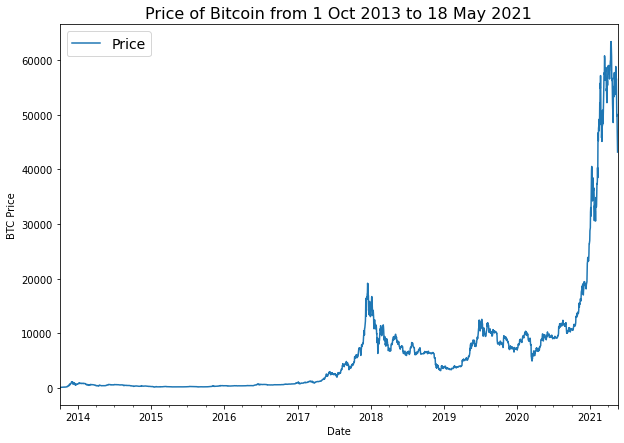

In [8]:
# Visulaizing data
import matplotlib.pyplot as plt
bitcoin_prices.plot(figsize=(10, 7))
plt.ylabel('BTC Price')
plt.title('Price of Bitcoin from 1 Oct 2013 to 18 May 2021', fontsize=16)
plt.legend(fontsize=14)

### Importing time series data with Python's CSV module

In [9]:
# Importing and formatting historical Bitcoin data with Python

import csv
from datetime import datetime

timesteps = []
btc_price = []
with open('/content/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv') as f:
  csv_reader = csv.reader(f, delimiter=',')
  next(csv_reader)
  for line in csv_reader:
    timesteps.append(datetime.strptime(line[1], "%Y-%m-%d"))
    btc_price.append(float(line[2]))

# View first 10 of each

timesteps[:10], btc_price[:10]

([datetime.datetime(2013, 10, 1, 0, 0),
  datetime.datetime(2013, 10, 2, 0, 0),
  datetime.datetime(2013, 10, 3, 0, 0),
  datetime.datetime(2013, 10, 4, 0, 0),
  datetime.datetime(2013, 10, 5, 0, 0),
  datetime.datetime(2013, 10, 6, 0, 0),
  datetime.datetime(2013, 10, 7, 0, 0),
  datetime.datetime(2013, 10, 8, 0, 0),
  datetime.datetime(2013, 10, 9, 0, 0),
  datetime.datetime(2013, 10, 10, 0, 0)],
 [123.65499,
  125.455,
  108.58483,
  118.67466,
  121.33866,
  120.65533,
  121.795,
  123.033,
  124.049,
  125.96116])

Text(0.5, 0, 'Date')

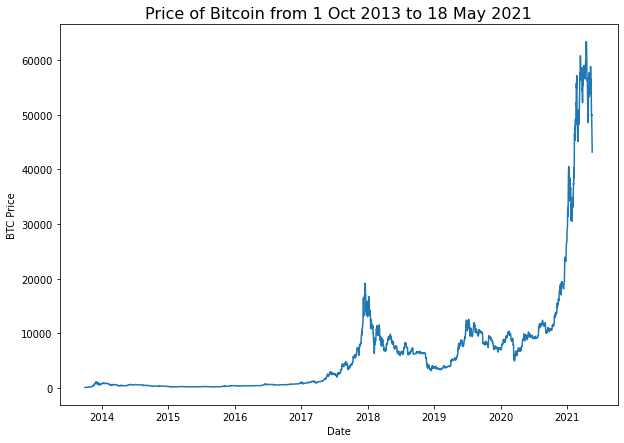

In [10]:
# Plot from CSV
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 7))
plt.plot(timesteps, btc_price)
plt.ylabel('BTC Price')
plt.title('Price of Bitcoin from 1 Oct 2013 to 18 May 2021', fontsize=16)
plt.xlabel('Date')

## Formatting data for time series problem

### Creating train and test sets for time series data (the wrong way)

In [11]:
# Get Bitcoin date array

timesteps = bitcoin_prices.index.to_numpy()
prices = bitcoin_prices['Price'].to_numpy()

timesteps[:10], prices[:10]

(array(['2013-10-01T00:00:00.000000000', '2013-10-02T00:00:00.000000000',
        '2013-10-03T00:00:00.000000000', '2013-10-04T00:00:00.000000000',
        '2013-10-05T00:00:00.000000000', '2013-10-06T00:00:00.000000000',
        '2013-10-07T00:00:00.000000000', '2013-10-08T00:00:00.000000000',
        '2013-10-09T00:00:00.000000000', '2013-10-10T00:00:00.000000000'],
       dtype='datetime64[ns]'),
 array([123.65499, 125.455  , 108.58483, 118.67466, 121.33866, 120.65533,
        121.795  , 123.033  , 124.049  , 125.96116]))

In [12]:
# Wrong way to make train test split

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(timesteps,
                                                    prices,
                                                    test_size=0.2,
                                                    random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((2229,), (558,), (2229,), (558,))

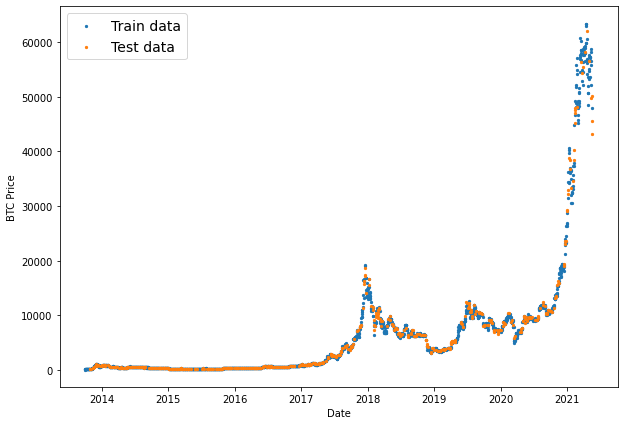

In [13]:
# Plotting wrong train and test splits

plt.figure(figsize=(10, 7))
plt.scatter(X_train, y_train, s=5, label='Train data')
plt.scatter(X_test, y_test, s=5, label='Test data')
plt.xlabel('Date')
plt.ylabel('BTC Price')
plt.legend(fontsize=14)
plt.show()

### Creating train and test sets for time series data (the right way)

In [14]:
split_size = int(0.8 * len(prices))

X_train, y_train = timesteps[0:split_size], prices[:split_size]

X_test, y_test = timesteps[split_size:], prices[split_size:]

len(X_train), len(X_test), len(y_train), len(y_test)

(2229, 558, 2229, 558)

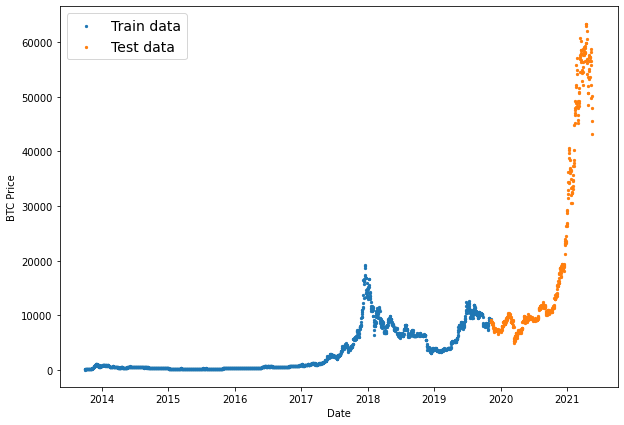

In [15]:
# Plot correctly made splits

plt.figure(figsize=(10, 7))
plt.scatter(X_train, y_train, s=5, label='Train data')
plt.scatter(X_test, y_test, s=5, label='Test data')
plt.xlabel('Date')
plt.ylabel('BTC Price')
plt.legend(fontsize=14)
plt.show()

### Creating a plotting function

In [16]:
def plot_time_series(timesteps, values, format='.', start=0, end=None, label=None):
  plt.plot(timesteps[start:end], values[start:end], format, label=label)
  plt.xlabel('Time')
  plt.ylabel('BTC Price')
  if label:
    plt.legend(fontsize=14)
  plt.grid(True) 

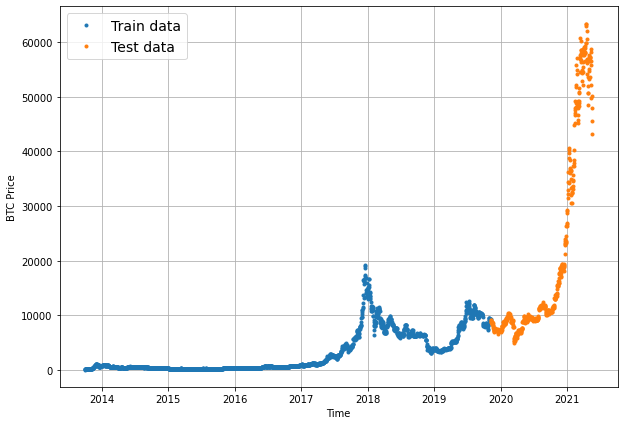

In [17]:
# Try out our plotting function

plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_train, values=y_train, label='Train data')
plot_time_series(timesteps=X_test, values=y_test, label='Test data')

## Modelling Experiments

### Model 0: Naive Forecast (baseline)

In [18]:
# Create a naive forecast

naive_forecast = y_test[:-1]
naive_forecast[:10], naive_forecast[-10:]

(array([9226.48582088, 8794.35864452, 8798.04205463, 9081.18687849,
        8711.53433917, 8760.89271814, 8749.52059102, 8656.97092235,
        8500.64355816, 8469.2608989 ]),
 array([57107.12067189, 58788.20967893, 58102.19142623, 55715.54665129,
        56573.5554719 , 52147.82118698, 49764.1320816 , 50032.69313676,
        47885.62525472, 45604.61575361]))

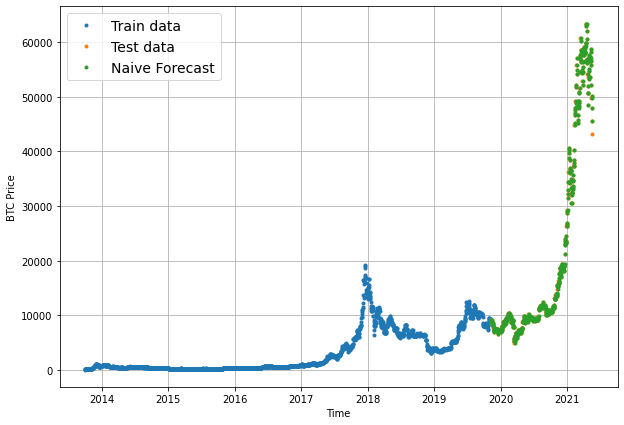

In [19]:
# Plot naive forecast

plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_train, values=y_train, label='Train data')
plot_time_series(timesteps=X_test, values=y_test, label='Test data')
plot_time_series(timesteps=X_test[1:], values=naive_forecast, label='Naive Forecast')

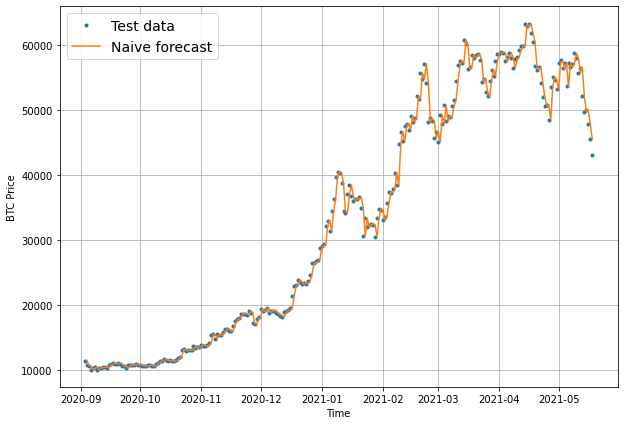

In [20]:
# Zooming in the plot

plt.figure(figsize=(10, 7))
offset = 300
plot_time_series(timesteps=X_test, values=y_test, start=offset, label='Test data')
plot_time_series(timesteps=X_test[1:], values=naive_forecast, start=offset, format='-', label='Naive forecast')


### Evaluating a time series model

In [21]:
import tensorflow as tf

In [22]:
# Create a function to calculate MASE (mean absolute scaled error)

def mean_absolute_scaled_error(y_true, y_pred):
  
  mae = tf.reduce_mean(tf.abs(y_true - y_pred))
  mae_naive_no_season = tf.reduce_mean(tf.abs(y_true[1:]-y_true[:-1]))
  
  return mae/mae_naive_no_season

In [23]:
# Create a function to calculate results (predictions)

def evaluate_preds(y_true, y_pred):

  y_true = tf.cast(y_true, dtype=tf.float32)
  y_pred = tf.cast(y_pred, dtype=tf.float32)

  mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
  mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)
  mse = tf.keras.metrics.mean_squared_error(y_true, y_pred)
  rmse = tf.sqrt(mse)
  mase = mean_absolute_scaled_error(y_true, y_pred)

  return {"mae": mae.numpy(),
          "mse": mse.numpy(),
          "rmse": rmse.numpy(),
          "mape": mape.numpy(),
          "mase": mase.numpy()}

In [24]:
naive_results = evaluate_preds(y_true=y_test[1:], y_pred=naive_forecast)
naive_results

{'mae': 567.9802,
 'mse': 1147547.0,
 'rmse': 1071.2362,
 'mape': 2.516525,
 'mase': 0.99957}

### Other models/libraries for time series forecasting
  * Moving average
  * ARIMA (AutoRegression Integrated Moving Average)
  * Sktime (Scikit-learn for time series)
  * TensorFlow Decision Forecasts (random forest, gradient boosting trees)
  * Facebook Kats (purpose built forecasting and time series analysis library by facebook)
  * LinkedIn Greykite (flexible, intuitive and fast forecasts)


### Windowing dataset

In [25]:
HORIZON = 1           # Predict 1 step at a time
WINDOW_SIZE = 7       # Use a week worth of timestamps to predict the horizon

In [26]:
# Create a function to label windowed data

def get_labelled_windows(x, horizon=1):

  return x[:,:-horizon], x[:,-horizon:]

In [27]:
# Test out the window labelling function

test_window, test_label = get_labelled_windows(tf.expand_dims(tf.range(8)+1, axis=0), horizon=HORIZON)
print(f"Window: {test_window} -> Label: {test_label}")

Window: [[1 2 3 4 5 6 7]] -> Label: [[8]]


In [28]:
# Create a function to view NumPy arrays as windows

def make_windows(x, window_size=7, horizon=1):

  # 1. Create a window of specific window size (add the horizon on the end for later labelling)
  window_step = np.expand_dims(np.arange(window_size+horizon), axis=0)

  # 2. Create a 2D array of multiple window steps (minus 1 to account for zero indexing)
  window_indexes = window_step + np.expand_dims(np.arange(len(x) - (window_size+horizon-1)), axis=0).T

  # 3. Index on the target array (time series) with 2D array of multiple window steps
  windowed_array = x[window_indexes]

  # 4. Get the labelled windows
  windows, labels = get_labelled_windows(windowed_array, horizon=horizon)

  return windows, labels

In [29]:
full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

(2780, 2780)

In [30]:
# View the first three windows/labels

for i in range(3):
  print(f"Window: {full_windows[i]} -> Label: {full_labels[i]}")

Window: [123.65499 125.455   108.58483 118.67466 121.33866 120.65533 121.795  ] -> Label: [123.033]
Window: [125.455   108.58483 118.67466 121.33866 120.65533 121.795   123.033  ] -> Label: [124.049]
Window: [108.58483 118.67466 121.33866 120.65533 121.795   123.033   124.049  ] -> Label: [125.96116]


### Turning windows into training and test sets

In [31]:
# Make the train test split

def make_train_test_split(windows, labels, test_split=0.2):

  split_size = int(len(windows) * (1-test_split))
  train_windows = windows[:split_size]
  train_labels = labels[:split_size]
  test_windows = windows[split_size:]
  test_labels = labels[split_size:]

  return train_windows, test_windows, train_labels, test_labels

In [32]:
train_windows, test_windows, train_labels, test_labels = make_train_test_split(full_windows, full_labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2224, 556, 2224, 556)

In [33]:
train_windows[:5], train_labels[:5]

(array([[123.65499, 125.455  , 108.58483, 118.67466, 121.33866, 120.65533,
         121.795  ],
        [125.455  , 108.58483, 118.67466, 121.33866, 120.65533, 121.795  ,
         123.033  ],
        [108.58483, 118.67466, 121.33866, 120.65533, 121.795  , 123.033  ,
         124.049  ],
        [118.67466, 121.33866, 120.65533, 121.795  , 123.033  , 124.049  ,
         125.96116],
        [121.33866, 120.65533, 121.795  , 123.033  , 124.049  , 125.96116,
         125.27966]]), array([[123.033  ],
        [124.049  ],
        [125.96116],
        [125.27966],
        [125.9275 ]]))

### Make modelling checkpoint

In [34]:
import os

# Create a function ti implement model checkpoint callback with a specific filename

def create_model_checkpoint(model_name, save_path="model_experiments"):
  
  return tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(save_path, model_name),
                                            verbose=0,
                                            save_best_only=True)

### Model 1: Dense model (window = 7, horizon = 1)

In [35]:
import tensorflow as tf
from tensorflow.keras import layers

# Set seed
tf.random.set_seed(42)

# Construct model
model_1 = tf.keras.Sequential([
    layers.Dense(128, activation="relu"),
    layers.Dense(HORIZON, activation="linear")
], name="model_1_dense")

# Compile model
model_1.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["mae"])

# Fit model
model_1.fit(x=train_windows,
            y=train_labels,
            epochs=100,
            verbose=1,
            batch_size=128,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_1.name)])

Epoch 1/100
11/18 [=================>............] - ETA: 0s - loss: 534.7814 - mae: 534.7814    

18/18 [==============================] - 10s 116ms/step - loss: 445.4872 - mae: 445.4872 - val_loss: 1501.2556 - val_mae: 1501.2556
Epoch 2/100
18/18 [==============================] - ETA: 0s - loss: 211.6121 - mae: 211.6121

18/18 [==============================] - 1s 71ms/step - loss: 211.6121 - mae: 211.6121 - val_loss: 1172.2086 - val_mae: 1172.2086
Epoch 3/100
16/18 [=========================>....] - ETA: 0s - loss: 185.1749 - mae: 185.1749

18/18 [==============================] - 2s 100ms/step - loss: 182.4672 - mae: 182.4672 - val_loss: 1009.5023 - val_mae: 1009.5023
Epoch 4/100
17/18 [===========================>..] - ETA: 0s - loss: 173.3947 - mae: 173.3947

18/18 [==============================] - 2s 140ms/step - loss: 171.5121 - mae: 171.5121 - val_loss: 960.3114 - val_mae: 960.3114
Epoch 5/100
17/18 [===========================>..] - ETA: 0s - loss: 165.6069 - mae: 165.6069

18/18 [==============================] - 1s 81ms/step - loss: 164.1090 - mae: 164.1090 - val_loss: 890.3367 - val_mae: 890.3367
Epoch 6/100
18/18 [==============================] - 0s 16ms/step - loss: 166.4735 - mae: 166.4735 - val_loss: 910.9880 - val_mae: 910.9880
Epoch 7/100
17/18 [===========================>..] - ETA: 0s - loss: 156.5041 - mae: 156.5041

18/18 [==============================] - 1s 63ms/step - loss: 156.0130 - mae: 156.0130 - val_loss: 809.8968 - val_mae: 809.8968
Epoch 8/100
14/18 [======================>.......] - ETA: 0s - loss: 143.7148 - mae: 143.7148

18/18 [==============================] - 1s 70ms/step - loss: 144.1684 - mae: 144.1684 - val_loss: 795.5741 - val_mae: 795.5741
Epoch 9/100
16/18 [=========================>....] - ETA: 0s - loss: 146.3791 - mae: 146.3791

18/18 [==============================] - 1s 38ms/step - loss: 143.6204 - mae: 143.6204 - val_loss: 756.3806 - val_mae: 756.3806
Epoch 10/100
18/18 [==============================] - ETA: 0s - loss: 137.3962 - mae: 137.3962

18/18 [==============================] - 1s 37ms/step - loss: 137.3962 - mae: 137.3962 - val_loss: 731.5561 - val_mae: 731.5561
Epoch 11/100
17/18 [===========================>..] - ETA: 0s - loss: 131.6959 - mae: 131.6959

18/18 [==============================] - 1s 36ms/step - loss: 130.9842 - mae: 130.9842 - val_loss: 725.4673 - val_mae: 725.4673
Epoch 12/100
18/18 [==============================] - 0s 7ms/step - loss: 127.8130 - mae: 127.8130 - val_loss: 792.4505 - val_mae: 792.4505
Epoch 13/100
18/18 [==============================] - 0s 6ms/step - loss: 134.9944 - mae: 134.9944 - val_loss: 764.4218 - val_mae: 764.4218
Epoch 14/100
 1/18 [>.............................] - ETA: 0s - loss: 130.5890 - mae: 130.5890

18/18 [==============================] - 1s 36ms/step - loss: 125.0555 - mae: 125.0555 - val_loss: 664.6445 - val_mae: 664.6445
Epoch 15/100
18/18 [==============================] - 0s 6ms/step - loss: 123.3511 - mae: 123.3511 - val_loss: 669.1346 - val_mae: 669.1346
Epoch 16/100
18/18 [==============================] - 0s 5ms/step - loss: 118.4526 - mae: 118.4526 - val_loss: 680.0908 - val_mae: 680.0908
Epoch 17/100
 1/18 [>.............................] - ETA: 0s - loss: 104.4821 - mae: 104.4821

18/18 [==============================] - 1s 35ms/step - loss: 116.5723 - mae: 116.5723 - val_loss: 638.3796 - val_mae: 638.3796
Epoch 18/100
17/18 [===========================>..] - ETA: 0s - loss: 118.1107 - mae: 118.1107

18/18 [==============================] - 1s 36ms/step - loss: 117.0500 - mae: 117.0500 - val_loss: 628.6786 - val_mae: 628.6786
Epoch 19/100
18/18 [==============================] - 0s 5ms/step - loss: 116.3830 - mae: 116.3830 - val_loss: 773.0541 - val_mae: 773.0541
Epoch 20/100
18/18 [==============================] - ETA: 0s - loss: 118.1536 - mae: 118.1536

18/18 [==============================] - 1s 36ms/step - loss: 118.1536 - mae: 118.1536 - val_loss: 617.5555 - val_mae: 617.5555
Epoch 21/100
18/18 [==============================] - 0s 5ms/step - loss: 116.7072 - mae: 116.7072 - val_loss: 630.6942 - val_mae: 630.6942
Epoch 22/100
17/18 [===========================>..] - ETA: 0s - loss: 116.1931 - mae: 116.1931

18/18 [==============================] - 1s 36ms/step - loss: 116.1170 - mae: 116.1170 - val_loss: 612.6387 - val_mae: 612.6387
Epoch 23/100
18/18 [==============================] - ETA: 0s - loss: 118.9536 - mae: 118.9536

18/18 [==============================] - 1s 39ms/step - loss: 118.9536 - mae: 118.9536 - val_loss: 607.4247 - val_mae: 607.4247
Epoch 24/100
18/18 [==============================] - 0s 8ms/step - loss: 118.5419 - mae: 118.5419 - val_loss: 623.9791 - val_mae: 623.9791
Epoch 25/100
18/18 [==============================] - 0s 8ms/step - loss: 112.6908 - mae: 112.6908 - val_loss: 615.3011 - val_mae: 615.3011
Epoch 26/100
10/18 [===============>..............] - ETA: 0s - loss: 113.5716 - mae: 113.5716

18/18 [==============================] - 1s 63ms/step - loss: 113.4122 - mae: 113.4122 - val_loss: 604.3959 - val_mae: 604.3959
Epoch 27/100
18/18 [==============================] - 0s 8ms/step - loss: 112.3690 - mae: 112.3690 - val_loss: 639.3118 - val_mae: 639.3118
Epoch 28/100
13/18 [====================>.........] - ETA: 0s - loss: 114.6613 - mae: 114.6613

18/18 [==============================] - 1s 50ms/step - loss: 114.9180 - mae: 114.9180 - val_loss: 600.3041 - val_mae: 600.3041
Epoch 29/100
18/18 [==============================] - 0s 5ms/step - loss: 110.2869 - mae: 110.2869 - val_loss: 615.2357 - val_mae: 615.2357
Epoch 30/100
 1/18 [>.............................] - ETA: 0s - loss: 126.3437 - mae: 126.3437

18/18 [==============================] - 1s 36ms/step - loss: 115.0707 - mae: 115.0707 - val_loss: 590.5516 - val_mae: 590.5516
Epoch 31/100
18/18 [==============================] - 0s 6ms/step - loss: 118.2030 - mae: 118.2030 - val_loss: 697.0140 - val_mae: 697.0140
Epoch 32/100
18/18 [==============================] - 0s 5ms/step - loss: 113.9371 - mae: 113.9371 - val_loss: 608.3583 - val_mae: 608.3583
Epoch 33/100
18/18 [==============================] - 0s 5ms/step - loss: 112.6019 - mae: 112.6019 - val_loss: 630.5641 - val_mae: 630.5641
Epoch 34/100
18/18 [==============================] - 0s 6ms/step - loss: 110.7354 - mae: 110.7354 - val_loss: 592.4791 - val_mae: 592.4791
Epoch 35/100
17/18 [===========================>..] - ETA: 0s - loss: 110.2163 - mae: 110.2163

18/18 [==============================] - 1s 35ms/step - loss: 109.9672 - mae: 109.9672 - val_loss: 585.1927 - val_mae: 585.1927
Epoch 36/100
 1/18 [>.............................] - ETA: 0s - loss: 155.5277 - mae: 155.5277

18/18 [==============================] - 1s 36ms/step - loss: 116.6583 - mae: 116.6583 - val_loss: 582.6672 - val_mae: 582.6672
Epoch 37/100
18/18 [==============================] - 0s 6ms/step - loss: 114.7805 - mae: 114.7805 - val_loss: 606.3294 - val_mae: 606.3294
Epoch 38/100
18/18 [==============================] - 0s 5ms/step - loss: 111.6956 - mae: 111.6956 - val_loss: 583.9776 - val_mae: 583.9776
Epoch 39/100
16/18 [=========================>....] - ETA: 0s - loss: 110.5032 - mae: 110.5032

18/18 [==============================] - 1s 37ms/step - loss: 108.7705 - mae: 108.7705 - val_loss: 580.1364 - val_mae: 580.1364
Epoch 40/100
18/18 [==============================] - 0s 6ms/step - loss: 108.8479 - mae: 108.8479 - val_loss: 596.9850 - val_mae: 596.9850
Epoch 41/100
18/18 [==============================] - 0s 5ms/step - loss: 109.6047 - mae: 109.6047 - val_loss: 628.0644 - val_mae: 628.0644
Epoch 42/100
18/18 [==============================] - 0s 6ms/step - loss: 113.2258 - mae: 113.2258 - val_loss: 620.8097 - val_mae: 620.8097
Epoch 43/100
18/18 [==============================] - 0s 5ms/step - loss: 110.4039 - mae: 110.4039 - val_loss: 663.4955 - val_mae: 663.4955
Epoch 44/100
18/18 [==============================] - 0s 6ms/step - loss: 112.2384 - mae: 112.2384 - val_loss: 590.8779 - val_mae: 590.8779
Epoch 45/100
18/18 [==============================] - 0s 7ms/step - loss: 109.0315 - mae: 109.0315 - val_loss: 601.4999 - val_mae: 601.4999
Epoch 46/100
18/18 [============

18/18 [==============================] - 1s 51ms/step - loss: 110.8683 - mae: 110.8683 - val_loss: 576.1506 - val_mae: 576.1506
Epoch 53/100
18/18 [==============================] - 0s 6ms/step - loss: 109.8928 - mae: 109.8928 - val_loss: 596.3461 - val_mae: 596.3461
Epoch 54/100
18/18 [==============================] - 0s 6ms/step - loss: 108.1258 - mae: 108.1258 - val_loss: 600.0668 - val_mae: 600.0668
Epoch 55/100
18/18 [==============================] - 0s 7ms/step - loss: 116.1647 - mae: 116.1647 - val_loss: 578.5346 - val_mae: 578.5346
Epoch 56/100
18/18 [==============================] - 0s 6ms/step - loss: 110.3848 - mae: 110.3848 - val_loss: 794.2667 - val_mae: 794.2667
Epoch 57/100
18/18 [==============================] - 0s 5ms/step - loss: 129.4376 - mae: 129.4376 - val_loss: 805.4193 - val_mae: 805.4193
Epoch 58/100
18/18 [==============================] - 0s 5ms/step - loss: 119.1495 - mae: 119.1495 - val_loss: 643.7413 - val_mae: 643.7413
Epoch 59/100
18/18 [============

18/18 [==============================] - 1s 36ms/step - loss: 107.5648 - mae: 107.5648 - val_loss: 575.3683 - val_mae: 575.3683
Epoch 61/100
18/18 [==============================] - 0s 6ms/step - loss: 107.3610 - mae: 107.3610 - val_loss: 576.7890 - val_mae: 576.7890
Epoch 62/100
18/18 [==============================] - 0s 5ms/step - loss: 107.5706 - mae: 107.5706 - val_loss: 593.3483 - val_mae: 593.3483
Epoch 63/100
18/18 [==============================] - 0s 5ms/step - loss: 110.0823 - mae: 110.0823 - val_loss: 664.3505 - val_mae: 664.3505
Epoch 64/100
18/18 [==============================] - 0s 6ms/step - loss: 109.5707 - mae: 109.5707 - val_loss: 579.8500 - val_mae: 579.8500
Epoch 65/100
17/18 [===========================>..] - ETA: 0s - loss: 108.0184 - mae: 108.0184

18/18 [==============================] - 1s 37ms/step - loss: 107.1476 - mae: 107.1476 - val_loss: 572.3912 - val_mae: 572.3912
Epoch 66/100
18/18 [==============================] - 0s 6ms/step - loss: 108.3627 - mae: 108.3627 - val_loss: 577.4187 - val_mae: 577.4187
Epoch 67/100
18/18 [==============================] - 0s 6ms/step - loss: 110.1002 - mae: 110.1002 - val_loss: 601.7808 - val_mae: 601.7808
Epoch 68/100
18/18 [==============================] - 0s 5ms/step - loss: 114.9843 - mae: 114.9843 - val_loss: 746.3689 - val_mae: 746.3689
Epoch 69/100
18/18 [==============================] - 0s 6ms/step - loss: 125.8539 - mae: 125.8539 - val_loss: 608.4379 - val_mae: 608.4379
Epoch 70/100
18/18 [==============================] - 0s 6ms/step - loss: 128.6609 - mae: 128.6609 - val_loss: 576.1097 - val_mae: 576.1097
Epoch 71/100
18/18 [==============================] - 0s 6ms/step - loss: 112.8127 - mae: 112.8127 - val_loss: 586.3662 - val_mae: 586.3662
Epoch 72/100
18/18 [============

18/18 [==============================] - 1s 35ms/step - loss: 107.0126 - mae: 107.0126 - val_loss: 569.0294 - val_mae: 569.0294
Epoch 74/100
18/18 [==============================] - 0s 6ms/step - loss: 109.7855 - mae: 109.7855 - val_loss: 571.6378 - val_mae: 571.6378
Epoch 75/100
18/18 [==============================] - ETA: 0s - loss: 107.5645 - mae: 107.5645

18/18 [==============================] - 1s 50ms/step - loss: 107.5645 - mae: 107.5645 - val_loss: 568.7120 - val_mae: 568.7120
Epoch 76/100
18/18 [==============================] - 0s 8ms/step - loss: 107.8805 - mae: 107.8805 - val_loss: 569.4167 - val_mae: 569.4167
Epoch 77/100
18/18 [==============================] - 0s 8ms/step - loss: 108.4672 - mae: 108.4672 - val_loss: 599.7966 - val_mae: 599.7966
Epoch 78/100
18/18 [==============================] - 0s 8ms/step - loss: 106.3618 - mae: 106.3618 - val_loss: 575.0457 - val_mae: 575.0457
Epoch 79/100
18/18 [==============================] - 0s 8ms/step - loss: 106.2165 - mae: 106.2165 - val_loss: 582.6190 - val_mae: 582.6190
Epoch 80/100
18/18 [==============================] - 0s 9ms/step - loss: 108.8909 - mae: 108.8909 - val_loss: 575.3475 - val_mae: 575.3475
Epoch 81/100
10/18 [===============>..............] - ETA: 0s - loss: 105.6138 - mae: 105.6138

18/18 [==============================] - 1s 56ms/step - loss: 105.4620 - mae: 105.4620 - val_loss: 566.9283 - val_mae: 566.9283
Epoch 82/100
18/18 [==============================] - 0s 8ms/step - loss: 115.2803 - mae: 115.2803 - val_loss: 574.9020 - val_mae: 574.9020
Epoch 83/100
18/18 [==============================] - 0s 7ms/step - loss: 110.6481 - mae: 110.6481 - val_loss: 683.5012 - val_mae: 683.5012
Epoch 84/100
18/18 [==============================] - 0s 7ms/step - loss: 113.0159 - mae: 113.0159 - val_loss: 589.3488 - val_mae: 589.3488
Epoch 85/100
18/18 [==============================] - 0s 5ms/step - loss: 106.4714 - mae: 106.4714 - val_loss: 577.1330 - val_mae: 577.1330
Epoch 86/100
18/18 [==============================] - 0s 6ms/step - loss: 106.2032 - mae: 106.2032 - val_loss: 577.8674 - val_mae: 577.8674
Epoch 87/100
18/18 [==============================] - 0s 5ms/step - loss: 105.3967 - mae: 105.3967 - val_loss: 575.0468 - val_mae: 575.0468
Epoch 88/100
18/18 [============

In [36]:
# Evaluate model on test data

model_1.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 3ms/step - loss: 718.3880 - mae: 718.3880


[718.3880004882812, 718.3880004882812]

In [37]:
# Load in saved best performing model_1 and evaluate on test data

model_1 = tf.keras.models.load_model("model_experiments/model_1_dense")
model_1.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 3ms/step - loss: 566.9283 - mae: 566.9283


[566.9282836914062, 566.9282836914062]

### Making forecast with model (on the test dataset)

In [38]:
def make_preds(model, input_data):

  forecast = model.predict(input_data)

  return tf.squeeze(forecast)

In [39]:
# Make prediction using model_1 on the test dataset and view the results

model_1_preds = make_preds(model_1, test_windows)
len(model_1_preds), model_1_preds[:10]

18/18 [==============================] - 0s 2ms/step


(556, <tf.Tensor: shape=(10,), dtype=float32, numpy=
 array([8836.921, 8757.482, 9039.414, 8789.701, 8710.982, 8742.09 ,
        8663.322, 8534.249, 8437.885, 8528.862], dtype=float32)>)

In [40]:
# Evaluate preds

model_1_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_1_preds)
model_1_results

{'mae': 566.9283,
 'mse': 1161670.9,
 'rmse': 1077.8083,
 'mape': 2.5530632,
 'mase': 0.995936}

In [41]:
naive_results

{'mae': 567.9802,
 'mse': 1147547.0,
 'rmse': 1071.2362,
 'mape': 2.516525,
 'mase': 0.99957}

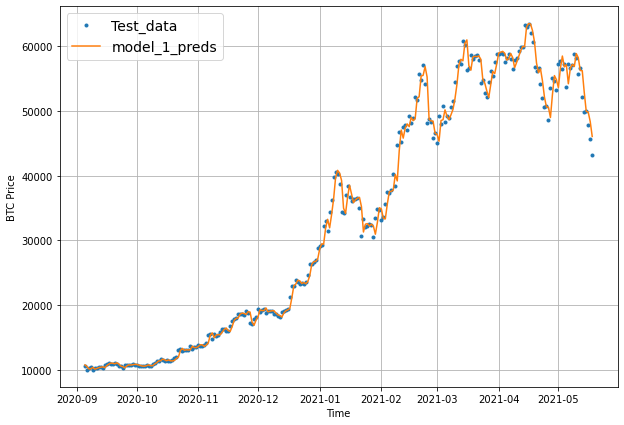

In [42]:
# Visualizing the result

offset = 300
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_test[-len(test_windows):], values=test_labels[:,0], start=offset, label="Test_data")
plot_time_series(timesteps=X_test[-len(test_windows):], values=model_1_preds, start=offset, format="-", label="model_1_preds")

### Model 2: Dense (window = 30, horizon = 1)

In [43]:
HORIZON = 1
WINDOW_SIZE = 30

In [44]:
# Make windowed data with appropriate horizon nad window size

full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

(2757, 2757)

In [45]:
# Make train and test windows

train_windows, test_windows, train_labels, test_labels = make_train_test_split(windows=full_windows,
                                                                               labels=full_labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2205, 552, 2205, 552)

In [46]:
tf.random.set_seed(42)

# Create model
model_2 = tf.keras.Sequential([
    layers.Dense(128, activation="relu"),
    layers.Dense(HORIZON)
], name="model_2_dense")

# Compile model
model_2.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

# Fit the model
model_2.fit(train_windows,
            train_labels,
            epochs=100,
            batch_size=128,
            verbose=0,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_2.name)])

In [47]:
# Evaluate model_2 preds

model_2.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 2ms/step - loss: 608.1940


608.1940307617188

In [48]:
# Load in best performing model

model_2 = tf.keras.models.load_model("model_experiments/model_2_dense")
model_2.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 2ms/step - loss: 608.1940


608.1940307617188

In [49]:
# Get forecast predictions

model_2_preds = make_preds(model_2,
                           input_data=test_windows)
model_2_preds[-10:]

18/18 [==============================] - 0s 2ms/step


<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([57478.56 , 57877.082, 58834.88 , 57057.07 , 56351.25 , 54104.906,
       50614.21 , 50361.465, 49505.31 , 46554.797], dtype=float32)>

In [50]:
# Evaluate results for model_2 prediction

model_2_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_2_preds)

In [51]:
model_2_results

{'mae': 608.194,
 'mse': 1288427.9,
 'rmse': 1135.0894,
 'mape': 2.8037255,
 'mase': 1.0631291}

### Model 3: Dense (window = 30, horizon = 7)

In [52]:
HORIZON = 7
WINDOW_SIZE = 30

full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

(2751, 2751)

In [53]:
train_windows, test_windows, train_labels, test_labels = make_train_test_split(windows=full_windows, labels=full_labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2200, 551, 2200, 551)

In [54]:
tf.random.set_seed(42)

model_3 = tf.keras.Sequential([
    layers.Dense(128, activation="relu"),
    layers.Dense(HORIZON)
], name = "model_3_dense")

model_3.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

model_3.fit(train_windows,
            train_labels,
            batch_size=128,
            epochs=100,
            verbose=0,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_3.name)])

In [55]:
model_3.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 2ms/step - loss: 1419.7970


1419.7969970703125

In [56]:
model_3 = tf.keras.models.load_model("model_experiments/model_3_dense/")
model_3.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 5ms/step - loss: 1230.9417


1230.941650390625

In [57]:
model_3_preds = make_preds(model_3,
                           input_data=test_windows)
model_3_preds[-5:]

18/18 [==============================] - 0s 4ms/step


<tf.Tensor: shape=(5, 7), dtype=float32, numpy=
array([[56798.418, 57386.406, 58023.113, 55856.39 , 58192.46 , 58396.56 ,
        57570.1  ],
       [55372.09 , 56932.832, 57924.98 , 56749.336, 57389.258, 58674.914,
        58617.285],
       [57782.195, 59815.742, 59218.996, 57832.43 , 59025.53 , 59331.12 ,
        59029.86 ],
       [58161.574, 58621.69 , 59139.867, 58649.797, 58885.152, 60406.176,
        59688.465],
       [56793.324, 57381.395, 57021.06 , 57918.023, 58822.76 , 59940.883,
        60001.867]], dtype=float32)>

In [58]:
model_3_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_3_preds)
model_3_results

{'mae': array([  688.514   ,   368.15332 ,   289.29117 ,   535.4819  ,
          563.65344 ,   612.1047  ,   662.8931  ,   523.4155  ,
          415.2043  ,   578.50323 ,   846.86896 ,   880.2354  ,
          888.4588  ,   934.79816 ,   606.1621  ,   237.32191 ,
          156.79611 ,   265.14752 ,   321.19254 ,   234.7885  ,
          212.2883  ,   234.50537 ,   407.47574 ,   403.4822  ,
          132.18967 ,   183.6868  ,   114.19929 ,   167.38023 ,
          145.99162 ,   303.94574 ,   345.4119  ,   381.8603  ,
          413.95523 ,   335.4841  ,   311.48395 ,   341.25342 ,
          404.4388  ,   252.86307 ,   220.20654 ,   162.55455 ,
          489.73563 ,    90.6974  ,    87.997696,   141.49721 ,
          188.70654 ,   182.8508  ,   102.483604,   113.94698 ,
          140.30775 ,   121.229774,   135.16385 ,   201.18758 ,
          234.12688 ,   205.73633 ,   204.7876  ,   288.643   ,
          619.87634 ,   432.3978  ,   414.44205 ,   542.61096 ,
          277.01025 ,   165.08363

### Make our evaluation function work for larger horizon

In [59]:
def evaluate_preds(y_true, y_pred):

  y_true = tf.cast(y_true, dtype=tf.float32)
  y_pred = tf.cast(y_pred, dtype=tf.float32)

  # Calculate various metrics
  mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
  mse = tf.keras.metrics.mean_squared_error(y_true, y_pred)
  rmse = tf.sqrt(mse)
  mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)
  mase = mean_absolute_scaled_error(y_true, y_pred)

  # Account for different sized metrics (for longer horizons, reduce to single number)
  if mae.ndim > 0:
    mae = tf.reduce_mean(mae)
    mse = tf.reduce_mean(mse)
    rmse = tf.reduce_mean(rmse)
    mape = tf.reduce_mean(mape)
    mase = tf.reduce_mean(mase)
  
  return {"mae": mae.numpy(),
          "mse": mse.numpy(),
          "rmse": rmse.numpy(),
          "mape": mape.numpy(),
          "mase": mase.numpy()}

In [60]:
# Get model_3 reults

model_3_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_3_preds)
model_3_results

{'mae': 1230.9417,
 'mse': 5407848.5,
 'rmse': 1416.9521,
 'mape': 5.606264,
 'mase': 2.1903918}

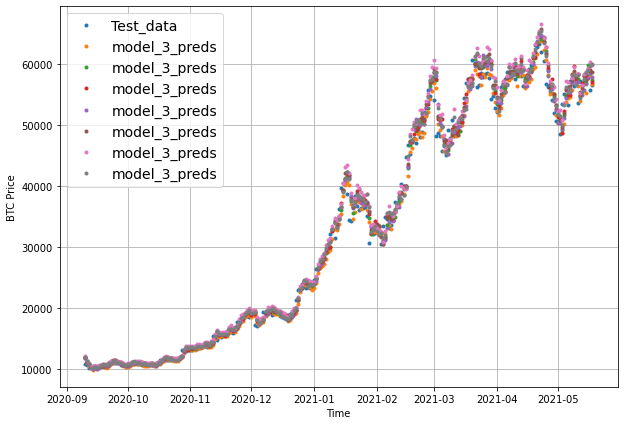

In [61]:
offset = 300
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_test[-len(test_windows):], values=test_labels[:, 0], start=offset, label="Test_data")
plot_time_series(timesteps=X_test[-len(test_windows):], values=model_3_preds, start=offset, label="model_3_preds")

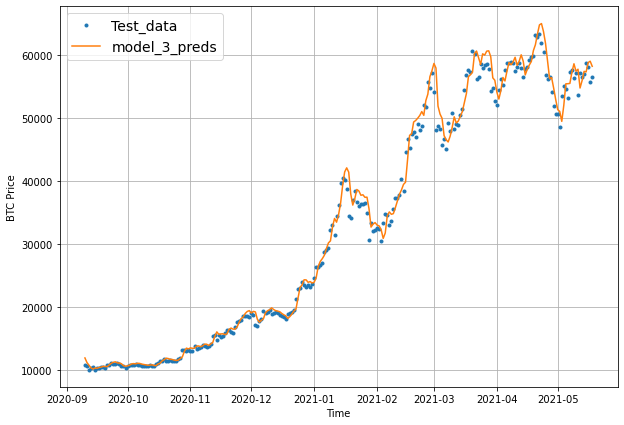

In [62]:
offset = 300
plt.figure(figsize=(10, 7))

plot_time_series(timesteps=X_test[-len(test_windows):], values=test_labels[:, 0], start=offset, label="Test_data")
plot_time_series(timesteps=X_test[-len(test_windows):], values=tf.reduce_mean(model_3_preds, axis=1), format="-", start=offset, label="model_3_preds")

### Which of our model is performing best so far?

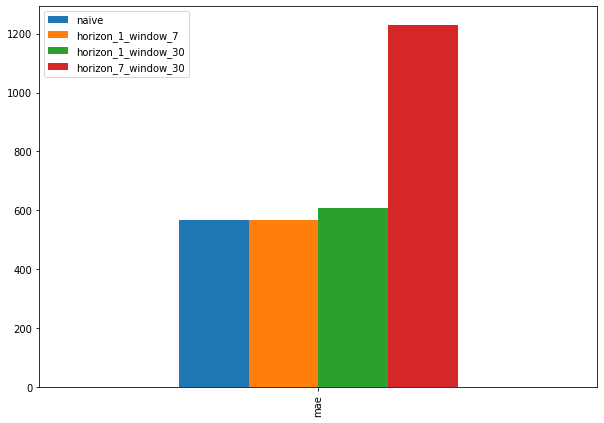

In [63]:
pd.DataFrame({"naive":naive_results["mae"],
              "horizon_1_window_7":model_1_results["mae"],
              "horizon_1_window_30":model_2_results["mae"],
              "horizon_7_window_30":model_3_results["mae"]}, index=["mae"]).plot(figsize=(10, 7), kind="bar");

### Model 4: Conv1D

In [64]:
HORIZON = 1
WINDOW_SIZE = 7

In [65]:
# Create windowed dataset

full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

(2780, 2780)

In [66]:
# Create test/train splits

train_windows, test_windows, train_labels, test_labels = make_train_test_split(full_windows, full_labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2224, 556, 2224, 556)

In [67]:
# Check data sample shapes
train_windows[0].shape

(7,)

In [68]:
# Before we pass our data to conv1D, we have to reshape it to make sure it works

x = tf.constant(train_windows[0])
expand_dims_layer = layers.Lambda(lambda x: tf.expand_dims(x, axis=1))
print(f"Original shape: {x.shape}")
print(f"Expanded shape: {expand_dims_layer(x).shape}")
print(f"Original values with Expanded shape:\n{expand_dims_layer(x)}")

Original shape: (7,)
Expanded shape: (7, 1)
Original values with Expanded shape:
[[123.65499]
 [125.455  ]
 [108.58483]
 [118.67466]
 [121.33866]
 [120.65533]
 [121.795  ]]


In [69]:
tf.random.set_seed(42)

# Create model
model_4 = tf.keras.Sequential([
    layers.Lambda(lambda x: tf.expand_dims(x, axis=1)),
    layers.Conv1D(filters=128, kernel_size=5, padding="causal", activation="relu"),
    layers.Dense(HORIZON)
], name="model_4_Conv1D")

model_4.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

model_4.fit(train_windows,
            train_labels,
            epochs=100,
            batch_size=128,
            verbose=0,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_4.name)])

In [70]:
model_4.summary()

Model: "model_4_Conv1D"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda_1 (Lambda)           (None, 1, 7)              0         
                                                                 
 conv1d (Conv1D)             (None, 1, 128)            4608      
                                                                 
 dense_6 (Dense)             (None, 1, 1)              129       
                                                                 
Total params: 4,737
Trainable params: 4,737
Non-trainable params: 0
_________________________________________________________________


In [71]:
model_4 = tf.keras.models.load_model("model_experiments/model_4_Conv1D")
model_4.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 4ms/step - loss: 572.8647


572.8646850585938

In [72]:
# Make predictions
model_4_preds = make_preds(model_4, test_windows)
model_4_preds[:5]

18/18 [==============================] - 0s 2ms/step


<tf.Tensor: shape=(5,), dtype=float32, numpy=array([8890.692, 8783.1  , 8997.221, 8783.527, 8742.618], dtype=float32)>

In [73]:
# Evaluate predictions

model_4_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_4_preds)
model_4_results

{'mae': 572.86475,
 'mse': 1188725.8,
 'rmse': 1090.287,
 'mape': 2.55887,
 'mase': 1.0063647}

### Model 5: RNN (LSTM)

In [74]:
tf.random.set_seed(42)

# Let's an LSTM model with the functional API
inputs = layers.Input(shape=(WINDOW_SIZE))
x = layers.Lambda(lambda x: tf.expand_dims(x, axis=1))(inputs)
# print(x.shape)
# x= layers.LSTM(128, activation="relu", return_sequences=True)(x)
x = layers.LSTM(128, activation="relu")(x)
# print(x.shape)
# Add another optional dense layer
# x = layers.Dense(32, activation="relu")(x)
output = layers.Dense(HORIZON)(x)
model_5 = tf.keras.Model(inputs=inputs, outputs=output, name="model_5_lstm")

# Compile the model
model_5.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

# Fit the model
model_5.fit(train_windows,
            train_labels,
            epochs=100,
            batch_size=128,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_5.name)])

Epoch 1/100
18/18 [==============================] - 5s 169ms/step - loss: 2993.9983 - val_loss: 13814.0459
Epoch 2/100
18/18 [==============================] - 3s 181ms/step - loss: 1168.0510 - val_loss: 1423.6866
Epoch 3/100
18/18 [==============================] - 2s 127ms/step - loss: 265.0765 - val_loss: 1195.3529
Epoch 4/100
18/18 [==============================] - 2s 130ms/step - loss: 213.0583 - val_loss: 1105.2013
Epoch 5/100
18/18 [==============================] - 3s 156ms/step - loss: 197.1909 - val_loss: 1097.2769
Epoch 6/100
18/18 [==============================] - 2s 131ms/step - loss: 194.9022 - val_loss: 1074.2072
Epoch 7/100
18/18 [==============================] - 0s 7ms/step - loss: 190.1173 - val_loss: 1078.3977
Epoch 8/100
18/18 [==============================] - 3s 175ms/step - loss: 187.0622 - val_loss: 1073.3241
Epoch 9/100
18/18 [==============================] - 2s 128ms/step - loss: 185.3550 - val_loss: 1061.9874
Epoch 10/100
18/18 [=========================

In [75]:
# Load in the best version of model 5 and evaluate

model_5 = tf.keras.models.load_model("model_experiments/model_5_lstm/")
model_5.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 4ms/step - loss: 582.3916


582.3916015625

In [76]:
# Make prediction with our LSTM model

model_5_preds = make_preds(model_5, test_windows)
model_5_preds[:10]

18/18 [==============================] - 0s 2ms/step


<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([8929.234, 8811.878, 8972.287, 8793.298, 8746.958, 8719.464,
       8697.392, 8550.636, 8460.303, 8514.682], dtype=float32)>

In [77]:
# Evaluate model 5 preds

model_5_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_5_preds)
model_5_results

{'mae': 582.39166,
 'mse': 1220669.8,
 'rmse': 1104.8392,
 'mape': 2.6195514,
 'mase': 1.0231009}

### Make a multivariate time series

In [78]:
# Lets make a multivariate time series

bitcoin_prices.head()

,Price
Date,
2013-10-01,123.65499
2013-10-02,125.45500
2013-10-03,108.58483
2013-10-04,118.67466
2013-10-05,121.33866


In [79]:
# Block reward values

block_reward_1 = 50
block_reward_2 = 25
block_reward_3 = 12.5
block_reward_4 = 6.25

# Block reward dates

block_reward_2_datetime = np.datetime64("2012-11-28")
block_reward_3_datetime = np.datetime64("2016-07-09")
block_reward_4_datetime = np.datetime64("2020-05-11")

In [80]:
# Get datetime indexes for when to add in different block dates

block_reward_2_days = (block_reward_3_datetime - bitcoin_prices.index[0]).days
block_reward_3_days = (block_reward_4_datetime - bitcoin_prices.index[0]).days
block_reward_2_days, block_reward_3_days

(1012, 2414)

In [81]:
# Add block reward column

bitcoin_prices_block = bitcoin_prices.copy()
bitcoin_prices_block["block_reward"] = None

# Set values of block reward column

bitcoin_prices_block.iloc[:block_reward_2_days, -1] = block_reward_2
bitcoin_prices_block.iloc[block_reward_2_days: block_reward_3_days, -1] = block_reward_3
bitcoin_prices_block.iloc[block_reward_3_days:, -1] = block_reward_4
bitcoin_prices_block.head()

,Price,block_reward
Date,,
2013-10-01,123.65499,25
2013-10-02,125.45500,25
2013-10-03,108.58483,25
2013-10-04,118.67466,25
2013-10-05,121.33866,25


<AxesSubplot:xlabel='Date'>

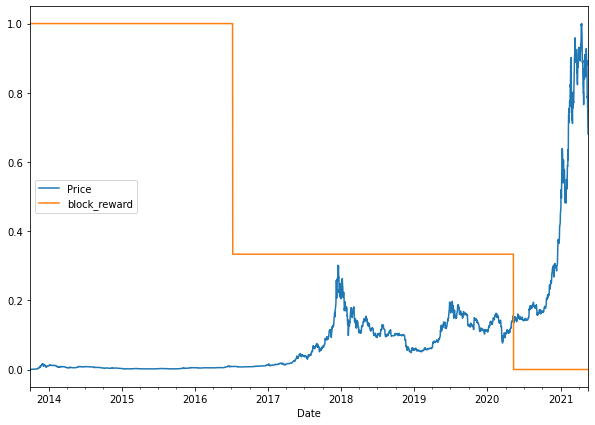

In [82]:
# Plot the block reward/price over time

from sklearn.preprocessing import minmax_scale
scaled_price_block_df = pd.DataFrame(minmax_scale(bitcoin_prices_block[["Price", "block_reward"]]),
                                     columns=bitcoin_prices_block.columns,
                                     index=bitcoin_prices_block.index)
scaled_price_block_df.plot(figsize=(10, 7))

### Making a windowed dataset with pandas

In [83]:
# Setup dataset hyperparameters

HORIZON = 1
WINDOW_SIZE = 7

In [84]:
# Make a copy of the bitcoin historical data with block reward feature

bitcoin_prices_windowed = bitcoin_prices_block.copy()

# Add windowed columns

for i in range(WINDOW_SIZE):
  bitcoin_prices_windowed[f"Price+{i+1}"] = bitcoin_prices_windowed["Price"].shift(periods=i+1)
bitcoin_prices_windowed.head(10)

,Price,block_reward,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,,
2013-10-01,123.65499,25,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-02,125.45500,25,123.65499,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-03,108.58483,25,125.45500,123.65499,NaN,NaN,NaN,NaN,NaN
2013-10-04,118.67466,25,108.58483,125.45500,123.65499,NaN,NaN,NaN,NaN
2013-10-05,121.33866,25,118.67466,108.58483,125.45500,123.65499,NaN,NaN,NaN
2013-10-06,120.65533,25,121.33866,118.67466,108.58483,125.45500,123.65499,NaN,NaN
2013-10-07,121.79500,25,120.65533,121.33866,118.67466,108.58483,125.45500,123.65499,NaN
2013-10-08,123.03300,25,121.79500,120.65533,121.33866,118.67466,108.58483,125.45500,123.65499
2013-10-09,124.04900,25,123.03300,121.79500,120.65533,121.33866,118.67466,108.58483,125.45500


In [85]:
# Lets create X & y, remove the Nans and convert to float32 to prevent TensorFlow errors

X = bitcoin_prices_windowed.dropna().drop("Price", axis=1).astype(np.float32)
y = bitcoin_prices_windowed.dropna()["Price"].astype(np.float32)
X.head()

,block_reward,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,
2013-10-08,25.0,121.794998,120.655327,121.338661,118.674660,108.584831,125.455002,123.654991
2013-10-09,25.0,123.032997,121.794998,120.655327,121.338661,118.674660,108.584831,125.455002
2013-10-10,25.0,124.049004,123.032997,121.794998,120.655327,121.338661,118.674660,108.584831
2013-10-11,25.0,125.961159,124.049004,123.032997,121.794998,120.655327,121.338661,118.674660
2013-10-12,25.0,125.279663,125.961159,124.049004,123.032997,121.794998,120.655327,121.338661


In [86]:
# View labels

y.head()

Date
2013-10-08    123.032997
2013-10-09    124.049004
2013-10-10    125.961159
2013-10-11    125.279663
2013-10-12    125.927498
Name: Price, dtype: float32

In [87]:
# Make train and tests

split_size = int(len(X)*0.8)
X_train, y_train = X[:split_size], y[:split_size]
X_test, y_test = X[split_size:], y[split_size:]
len(X_train), len(y_train), len(X_test), len(y_test)

(2224, 2224, 556, 556)

### Model 6: Dense (multivariate time series)

In [88]:
# Make multivariate time series model

tf.random.set_seed(42)
model_6 = tf.keras.Sequential([
    layers.Dense(128, activation="relu"),
    # Layers.Dense(128, activation="relu"), # Adding an extra layer here should lead to beating the native model
    layers.Dense(HORIZON)
], name="model_6_dense_multivariate")

# Compile
model_6.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

# Fit
model_6.fit(X_train, y_train,
            epochs=100,
            batch_size=128,
            verbose=0,
            validation_data=(X_test, y_test),
            callbacks=[create_model_checkpoint(model_name=model_6.name)])

In [89]:
# Make sure best model is loaded and evaluate

model_6 = tf.keras.models.load_model("model_experiments/model_6_dense_multivariate")
model_6.evaluate(X_test, y_test)

18/18 [==============================] - 0s 3ms/step - loss: 565.2197


565.2196655273438

In [90]:
# Make predictions on multivariate data
model_6_preds = tf.squeeze(model_6.predict(X_test))
model_6_preds[:10]

18/18 [==============================] - 0s 2ms/step


<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([8830.913, 8787.052, 9042.701, 8755.445, 8763.53 , 8751.738,
       8649.444, 8537.774, 8459.036, 8528.798], dtype=float32)>

In [91]:
# Evaluate preds

model_6_results = evaluate_preds(y_true=y_test,
                                 y_pred=model_6_preds)
model_6_results

{'mae': 565.2197,
 'mse': 1155614.1,
 'rmse': 1074.995,
 'mape': 2.5275352,
 'mase': 0.9929345}

In [92]:
model_1_results

{'mae': 566.9283,
 'mse': 1161670.9,
 'rmse': 1077.8083,
 'mape': 2.5530632,
 'mase': 0.995936}

### Model 7: N-BEATS algorithm

In [93]:
# Create NBeatsBlock custom layer

class NBeatsBlock(tf.keras.layers.Layer):
  def __init__(self, # the constructor takes all the hyperparameters for the layer
               input_size: int,
               theta_size: int,
               horizon: int,
               n_neurons: int,
               n_layers: int,
               **kwargs): # the **kwargs takes crae of all the parameters for the parent class
    super().__init__(**kwargs)
    self.input_size = input_size
    self.theta_size = theta_size
    self.horizon = horizon
    self.n_neurons = n_neurons
    self.n_layers = n_layers

    # Block contains stack of 4 fully connected layers each has ReLU activation
    self.hidden = [tf.keras.layers.Dense(n_neurons, activation="relu") for _ in range(n_layers)]
    # Output of block is theta layerwith linear activation
    self.theta_layer = tf.keras.layers.Dense(theta_size, activation="linear", name="theta")

  def call(self, inputs):
    x = inputs
    for layer in self.hidden:
      x = layer(x)
    theta = self.theta_layer(x)
    # Output the backcast and forecast from theta
    backcast, forecast = theta[:, :self.input_size], theta[:, -self.horizon]

    return backcast, forecast

In [94]:
# Setup dummy NBeatsBlock layer to represent inouts and outputs

dummy_nbeats_block_layer = NBeatsBlock(input_size=WINDOW_SIZE,
                                       theta_size=WINDOW_SIZE+HORIZON,
                                       horizon=HORIZON,
                                       n_neurons=128,
                                       n_layers=4)

In [95]:
# Create dummy inputs (have to be same size as input size)
dummy_inputs = tf.expand_dims(tf.range(WINDOW_SIZE)+1, axis=0)
dummy_inputs

<tf.Tensor: shape=(1, 7), dtype=int32, numpy=array([[1, 2, 3, 4, 5, 6, 7]], dtype=int32)>

In [96]:
# Pass dummy inputs to dummy NBeatsBlock layer
backcast, forecast = dummy_nbeats_block_layer(dummy_inputs)
print(f"Backcast: {tf.squeeze(backcast.numpy())}")
print(f"Forecast: {tf.squeeze(forecast.numpy())}")

Backcast: [-0.3060273   0.34917375  0.08881098  0.14983465 -0.3624347   0.5110376
 -0.30689695]
Forecast: 0.4749244451522827


### Preparing data for N-BEATS algorithm using tf.data

In [96]:
HORIZON = 1 # how far to predict
WINDOW_SIZE = 7 # how far to lookback

In [97]:
# Create NBEATS data inputs
bitcoin_prices.head()

,Price
Date,
2013-10-01,123.65499
2013-10-02,125.45500
2013-10-03,108.58483
2013-10-04,118.67466
2013-10-05,121.33866


In [99]:
# Add windowed columns
bitcoin_prices_nbeats = bitcoin_prices.copy()
for i in range(WINDOW_SIZE):
  bitcoin_prices_nbeats[f"Prices+{i+1}"] = bitcoin_prices_nbeats["Price"].shift(periods=i+1)
bitcoin_prices_nbeats.dropna().head()

,Price,Prices+1,Prices+2,Prices+3,Prices+4,Prices+5,Prices+6,Prices+7
Date,,,,,,,,
2013-10-08,123.03300,121.79500,120.65533,121.33866,118.67466,108.58483,125.45500,123.65499
2013-10-09,124.04900,123.03300,121.79500,120.65533,121.33866,118.67466,108.58483,125.45500
2013-10-10,125.96116,124.04900,123.03300,121.79500,120.65533,121.33866,118.67466,108.58483
2013-10-11,125.27966,125.96116,124.04900,123.03300,121.79500,120.65533,121.33866,118.67466
2013-10-12,125.92750,125.27966,125.96116,124.04900,123.03300,121.79500,120.65533,121.33866


In [102]:
# Make features and labels
X = bitcoin_prices_nbeats.dropna().drop("Price", axis=1)
y = bitcoin_prices_nbeats.dropna()['Price']

# Make train and test sets
split_size = int(len(X)*0.8)
X_train, y_train = X[:split_size], y[:split_size]
X_test, y_test = X[split_size:], y[split_size:]
len(X_train), len(X_test), len(y_train), len(y_test)

(2224, 556, 2224, 556)

In [103]:
# 1. Turn train and test sets into tensor datasets
train_features_dataset = tf.data.Dataset.from_tensor_slices(X_train)
train_labels_dataset = tf.data.Dataset.from_tensor_slices(y_train)

test_features_dataset = tf.data.Dataset.from_tensor_slices(X_test)
test_labels_dataset = tf.data.Dataset.from_tensor_slices(y_test)

# 2. Combine features and labels
train_dataset = tf.data.Dataset.zip((train_features_dataset, train_labels_dataset))
test_dataset = tf.data.Dataset.zip((test_features_dataset, test_labels_dataset))

# 3. Batch and prefetch for optimal performance
BATCH_SIZE = 1024
train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

train_dataset, test_dataset

(<PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>,
 <PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>)

### Setting up hyperparameters for N-BEATS algorithm

In [104]:
# Values from N-BEATS paper Figure 1 and Table 18/Appendix D

N_EPOCHS = 5000
N_NEURONS = 512
N_LAYERS = 4
N_STACKS = 30

INPUT_SIZE = WINDOW_SIZE * HORIZON
THETA_SIZE = INPUT_SIZE + HORIZON

INPUT_SIZE, THETA_SIZE

(7, 8)